Code related to the following paper: 
[1] Radu Dogaru and Ioana Dogaru, "BCONV-ELM: Binary Weights Convolutional Neural Network Simulator based on Keras/Tensorflow, for Low Complexity Implementations", Proceedings of the ISEEE 2019 conference, submitted.

Please cite the above paper if you found this code useful.
Copyright Radu and Ioana Dogaru correspondence: radu_d@ieee.org 

First two cells allow loading and preparing various datasest 
L-CNN is implemented in the third cell (it is trainable version of the lightweight architecture in [1]) 

In [ ]:
# Datasets from SKLEARN - here the ORL Face recognition 
# with possibility to select the fraction for training 

import keras
from sklearn import datasets as dat
import numpy as np
e=dat.fetch_olivetti_faces(data_home=None, shuffle=True, random_state=0, download_if_missing=True)

k1=300
toate=400
x_train=e.images[0:k1,:,:]
x_test=e.images[k1:toate,:,:]
y_train=e.target[0:k1]
y_test=e.target[k1:toate]

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST  
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1]) 
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] ) 
# place a  1 in the end to keep it compatible with kernel in conv2d 
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train=np.reshape(y_train, [np.shape(y_train)[0], 1]) 
y_test=np.reshape(y_test, [np.shape(y_test)[0], 1] ) 
num_classes=np.max(y_train)+1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
inp_chan=np.shape(x_train)[3]
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]

In [1]:
# Datasets from Keras
import numpy as np
import keras 

dataset='mnist' # mnist or f-mnist or cifar10 
reduced=0
dformat='channels_last'

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist

if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # incarca date nescalate 
elif  dataset=='cifar10': 
    (x_train, y_train), (x_test, y_test) = cifar10.load_data() # incarca date nescalate 
elif  dataset=='cifar100': 
    (x_train, y_train), (x_test, y_test) = cifar100.load_data() # incarca date nescalate 
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST  
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1]) 
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] ) 
# place a  1 in the end to keep it compatible with kernel in conv2d 
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255 
inp_chan=np.shape(x_train)[3] 
print('Number of input channels in image:', inp_chan)
num_classes=np.max(y_train)+1
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]


# one can choose a lower numbers of training samples (when GPU MEM is overloaded)
if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

11493376/11490434 [==============================] - 1s 0us/step
Number of input channels in image: 1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
activation_10 (Activation)   (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
__________

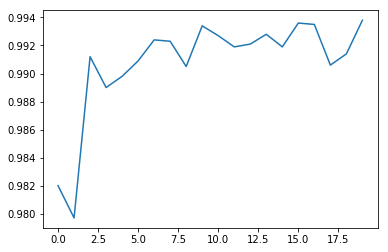

In [6]:
# L-CNN implementation 
# Up to 3 convolution layers + MLP0 (a linear output layer - additional 
# fully connected hidden layers may be added but the lightweight character 
# will be lost)
#-----------------  for reproductibility  ----------------------
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
#----------------------------------------------------

import keras
import numpy as np # linear algebra
import keras.backend as K 

import time as ti 
import scipy.io as sio

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D  # straturi convolutionale si max-pooling 
from keras.optimizers import RMSprop, SGD, Adadelta, Adam 

import matplotlib.pyplot as plt

#========================= Parameters (model and training)  ============================================
#
batch_size = 50  # useful for MNIST, CIFAR, for ORL take 1 
epoci = 20 # maximal number of training epochs (the best result may be obtained earlier)
train_style = 2 # 1-standard Keras (not recommended) ; 2 epoch by epoch and keeping best test accuracy until "epoci"; 
#--------------  Output layer MLP  (nhid1=nhid2=0 recommended for low complexity) 
nhid1 = 0 # hidden-1 neurons (put 0 if nhid2=0, or a desired value)
nhid2 = 0 # hidden-2 neurons (take 0 for 0 or 1 hidden layer)
#
# ----------------- CONV expander layers (up to 3) ------------------------------------------------------------
nr_conv=2 # 0, 1, 2 sau 3  (number of convolution layers)
filtre1=64 ; filtre2=64 ; filtre3=100  # filters (kernels) per each layer 
csize1=3; csize2=3 ; csize3=3      # convolution kernel size (square kernel) 
psize1=4; psize2=4 ; psize3=2      # pooling size (square)
str1=2; str2=2; str3=2             # stride pooling (downsampling rate) 
pad='same'; # padding style ('valid' is also an alternative)
type_conv=2 # 1='depth_wise' or 2='normal' 
# ------------------- Optimizer -----------------------------------------------------------------
#myopt = SGD(lr=0.01, decay=1e-6, momentum=.9, nesterov=True)
#myopt =Adadelta(lr=.1)  # implicit are lr=1 # cum influenteaza valoarea procesul de antrenare ?? 
myopt = RMSprop(lr=0.0005) 
#myopt = Adam(lr=0.001)
#myopt = Adam()
# --------------------------   LOSS function  ------------------------------------
#my_loss='mean_squared_error'  
#my_loss='mean_absolute_error'
my_loss='categorical_crossentropy'

#-------------------------- MODEL DESCRIPTION ------------------------------
model = Sequential()

if nr_conv>=1:
    if type_conv==2:
        model.add(Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape))
    elif type_conv==1:
        model.add(DepthwiseConv2D(kernel_size=csize2, padding=pad, input_shape=input_shape, depth_multiplier=filtre1, use_bias=False))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(psize1, psize1),strides=(str1,str1),padding=pad))
    #model.add(Activation('relu'))
    if nr_conv>=2:
        if type_conv==2:
            model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
        elif type_conv==1:
            model.add(DepthwiseConv2D(kernel_size=csize2, padding=pad, depth_multiplier=filtre2, use_bias=False))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(psize2, psize2),strides=(str2,str2),padding=pad))
        #model.add(Activation('relu'))
        if nr_conv==3:
            if type_conv==2:
                model.add(Conv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) )
            elif type_conv==1:
                model.add(DepthwiseConv2D(kernel_size=csize3, padding=pad, depth_multiplier=filtre3, use_bias=False))
            #model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
            #model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Flatten())
    #model.add(Activation('relu'))
    #model.add(Dropout(0.25))
elif nr_conv==0:
    model.add(Flatten(input_shape=input_shape))
# ---- first fc hidden layer  
if nhid1>0:
    model.add(Dense(nhid1, activation='relu'))
    #model.add(Dropout(0.5))
# ---- second fc hidden layer 
if nhid2>0:
    model.add(Dense(nhid2, activation='relu'))
#   model.add(Dropout(0.2))
#   output layer 
if (nhid1+nhid2)==0:
    model.add(Dense(num_classes, activation='softmax',input_shape=(num_inputs,)))
else: 
    model.add(Dense(num_classes, activation='softmax'))

model.summary()

# --- MODEL COMPILE --------------------------------------------------------

model.compile(loss=my_loss, 
              optimizer=myopt,   # se poate alege oricare dintre obiectele optimizer definite mai sus 
              metrics=['accuracy'])

# -   MODEL TRAINING --------------------------------------------------

if train_style==1: 
    t1=ti.time()
    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epoci,
                    verbose=2,  # aici 0 (nu afiseaza nimic) 1 (detaliat) 2(numai epocile)
                    validation_data=(x_test, y_test))
    t2=ti.time()
    print(t2-t1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
elif train_style==2:
    err_test=np.zeros(epoci)   # For plotting test error evolution  
    best_acc=0.0
    best_ep=0
    t1=ti.time()
    for k in range(epoci):
        model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=1,
              verbose=0,  # aici 0 (nu afiseaza nimic) 1 (detaliat) 2(numai epocile)
              validation_data=(x_test, y_test))
        
        score = model.evaluate(x_test, y_test, verbose=0)
        err_test[k]=score[1]
        if score[1]>best_acc : 
            print('Improved in epoch:', k, ' New accuracy: ', 100*score[1],'%')
            best_acc=score[1]
            best_ep=k
            bp=model.get_weights()
            
    t2=ti.time()
    print('Best accuracy:', best_acc*100, '% reached in epoch: ',best_ep, ' running  ',epoci,' epochs lasts ',t2-t1,' seconds')
    plt.plot(err_test)
    model.set_weights((bp)) # evaluete prediction time on all test samples
    t1=ti.time()
    score = model.evaluate(x_test, y_test, verbose=0)
    t2=ti.time()
    print('Test accuracy:', score[1])
    print ('Time for test set : ',t2-t1)
    print('Latency (per input sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')

In [ ]:
# QMLP0 (quantified MLP0 module)
# Quantization of the above resulted model (only for MLP0)
# Copyright Radu and Ioana DOGARU;  
#=============================================================
nb_out=8
outW=np.copy(bp)
Qout=-1+pow(2,nb_out-1)
if (nb_out >0) & (nhid1==0) :
    O=np.max(np.abs(outW[0]))
    outW[0]=np.round(outW[0]*(1/O)*Qout)
    outW[1]=np.round(outW[1]*(1/O)*Qout)
    model.set_weights(outW)
    score = model.evaluate(x_test, y_test, verbose=0)
    best_acc=score[1]
    print('Output layer quantized with:', nb_out, 'bits')
    print('Quantified accuracy is:', best_acc*100,'%')
outW=model.get_weights() # the resulting model with fixed point weights